# CS 361 SP20 Final Project Part 1

In this part, we do the following step to finish Exercise 9 in this final project, which requires us to implement two variants of Stochastic Optimization algorithm called ADAM and ADAGRAD

In [7]:
# Library Import
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
from IPython.display import display, HTML
np.set_printoptions(precision=3)

## Data Generation

### Constant Definition

In [8]:
dimension = 10
dataPoints = 1000
testDataPoints = 50
scale = .1

### Dataset Generation

In [9]:
# This is the most optimal result that we expect
theta_true = np.ones((dimension, 1))
# We make 1000 training data points. Each has 10 dimensions
# and the data points are selected randomly in between -1 to 1
A_data = np.random.uniform(low=-1.0, high=1.0, size=(dataPoints, dimension))
# Generate labels for each data points, which are also 10 dimensions.
y_data = np.matmul(A_data, theta_true) + np.random.normal(loc=0.0, scale=scale, size=(dataPoints, 1))
# Training test set
# Same to training data points, we generate 50 ten-dimensional test data points.
A_test = np.random.uniform(low=-1.0, high=1.0, size=(testDataPoints, dimension))
# Generate labels for testing data points, which are also 10 dimensions.
y_test = np.matmul(A_test, theta_true) + np.random.normal(loc=0.0, scale=scale, size=(testDataPoints, 1))

## Solving for the exact mean squared loss (solving Ax = b)

In order to calculate the most optimal solution for this equation: $Q_j(\theta) = |\mathbf{x}_{\mathbf{j}}^T \mathbf{\theta} - y_j |^2$, we take the derivative on both side, and we get the following equation: $2(|\mathbf{x}_{\mathbf{j}}^T \mathbf{\theta} - y_j |) \mathbf{x}_{\mathbf{j}}^T = 0$.

Therefore, we need to solve the following equation:
$$\mathbf{x}_{\mathbf{j}}^T \mathbf{\theta} - y_j = 0$$

Hints:
1. Use `np.matmul()` and `la.inv()` to solve for $x$ in $Ax = b$.
2. Use the defined variable $A$ in $Ax = b$. Use `y_data` as $b$. Use `theta_pred`as $x$.

In [10]:
theta_pred = np.zeros((dimension, 1))
for i in range(0, 1000, 10):
    theta_pred += np.matmul(la.inv(A_data[i:i+10, :]), y_data[i:i+10, :])
theta_pred /= 100
print('Empirical theta', theta_pred.reshape(-1))

Empirical theta [1.104 0.921 1.062 0.946 0.818 0.773 0.885 0.961 1.071 0.927]


## SGD Variants Noisy Function

Hints:
1. Find the gradient and loss for each data point `x`.
2. For `gradientUpdate`, you need `errorFunction`, `degree`, and `x`.
3. For `lossUpdate`, you need `errorFunction` and `degree` only.

In [11]:
def noisy_val_grad(theta_hat, data, label, degree=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0
    for i in range(data.shape[0]):
        x = data[i, :].reshape(-1,1) # x_j^T
        y = label[i, 0] # y_j
        errorFunction = np.sum(x * theta_hat) - y # error function
        gradientUpdate = degree * (np.abs(errorFunction) ** (degree - 1)) \
                                * x * np.sign(errorFunction)
        lossUpdate = np.abs(errorFunction) ** degree
        loss += lossUpdate / data.shape[0]
        gradient += gradientUpdate / data.shape[0]
    return loss, gradient

## Running SGD Variants

In [12]:
def SGD(method, trainData=A_data, trainLabel=y_data, testData=A_test, testLabel=y_test,
        learningRate=0.001, power=2., iteration=1000, replicate=10, batch=1,
        theta_init=np.random.random((10,1)) * 0.1, gradientNoise = 0., printTheta=False):
    assert method in ['adagrad', 'adam', 'sgd']
    testLossMatrix = []; trainLossMarix = []
    
    for r in range(replicate):
        if method == 'adam':
            beta_1 = 0.9; beta_2 = 0.999; m = 0; v = 0; epsilon = 1e-8;
        elif method == 'adagrad':
            epsilon = 1e-8; squared_sum = 0;
        elif method == 'sgd': pass
        
        theta_hat = theta_init.copy()
        testLossList = []; trainLossList = []
        
        for t in range(iteration):
            i = np.random.choice(iteration, batch)
            trainLoss, gradient = noisy_val_grad(theta_hat,
                            trainData[i,:], trainLabel[i,:], degree=power)
            gradient += np.random.randn(10,1) * gradientNoise \
                            + np.random.choice([-1, 1]) * 0.
            trainLossList.append(trainLoss)
            
            if t % len(testData) == 0:
                testLoss, _ = noisy_val_grad(theta_hat,
                            testData[:,:], testLabel[:,:], degree=power)
                testLossList.append(testLoss)
                
            if method == 'adam' and t != 0:
                m = m * beta_1 + (1 - beta_1) * gradient
                v = v * beta_2 + (1 - beta_2) * (gradient ** 2)
                m_hat = m / (1 - beta_1 ** t)
                v_hat = v / (1 - beta_2 ** t)
                theta_hat -= learningRate * m_hat / (np.sqrt(v_hat) + epsilon)
            elif method == 'adagrad':
                squared_sum += gradient ** 2
                theta_hat -= learningRate * gradient / np.sqrt(squared_sum + epsilon)
            elif method == 'sgd':
                theta_hat -= learningRate * gradient
                
        testLossMatrix.append(testLossList)
        trainLossMarix.append(trainLossList)
        
        if printTheta and r == 0: print(theta_hat.reshape(-1))
    
    testLossMatrix = np.array(testLossMatrix)
    testLossMean = np.mean(testLossMatrix, axis=0) 
    testLossStandardError = np.std(testLossMatrix, axis=0) / np.sqrt(replicate)
    
    x_axis = np.arange(iteration)[::len(testData)]
    plt.errorbar(x_axis, testLossMean, yerr=2.5*testLossStandardError, label=method)

## Testing Performances for Each Methods

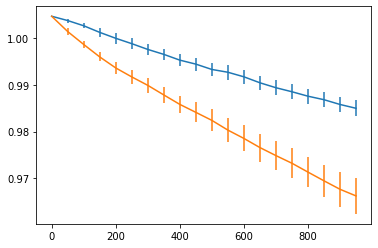

In [13]:
p = 0.4
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

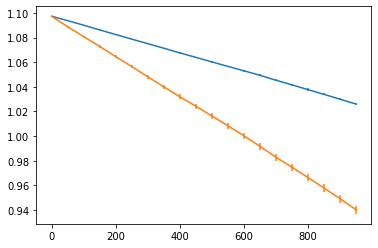

In [14]:
p = 0.7
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

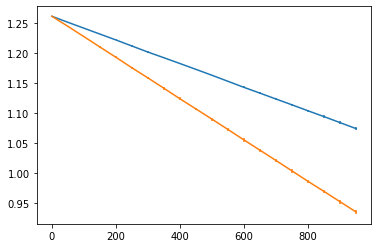

In [15]:
p = 1.0
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

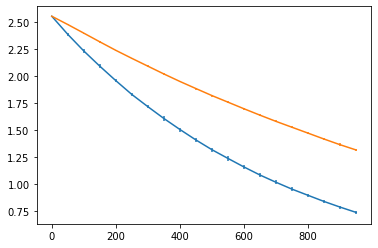

In [16]:
p = 2.0
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

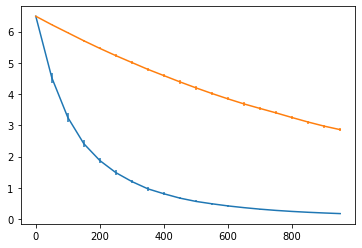

In [17]:
p = 3.0
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

<ipython-input-11-e54678bda62f>:10: RuntimeWarning: overflow encountered in double_scalars
  lossUpdate = np.abs(errorFunction) ** degree
<ipython-input-11-e54678bda62f>:8: RuntimeWarning: overflow encountered in double_scalars
  gradientUpdate = degree * (np.abs(errorFunction) ** (degree - 1)) \
/Users/int0thewind/Development/pythonenv/base/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


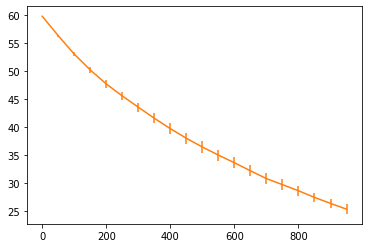

In [18]:
p = 5.0
SGD('sgd', power=p, replicate=50)
SGD('adam', power=p, replicate=50)

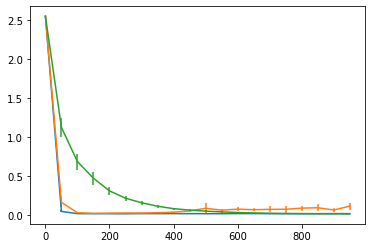

In [34]:
SGD('sgd',learningRate=0.1)
SGD('adam',learningRate=0.1)
SGD('adagrad',learningRate=0.1)

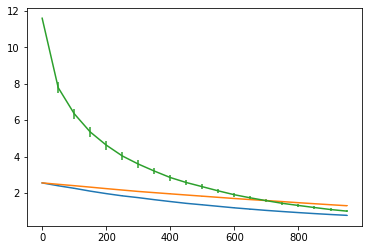

In [31]:
SGD('sgd')
SGD('adam')
SGD('adagrad', learningRate=0.1, theta_init=-np.ones((10, 1)))

No handles with labels found to put in legend.


Text(0.5, 0, 'Updates')

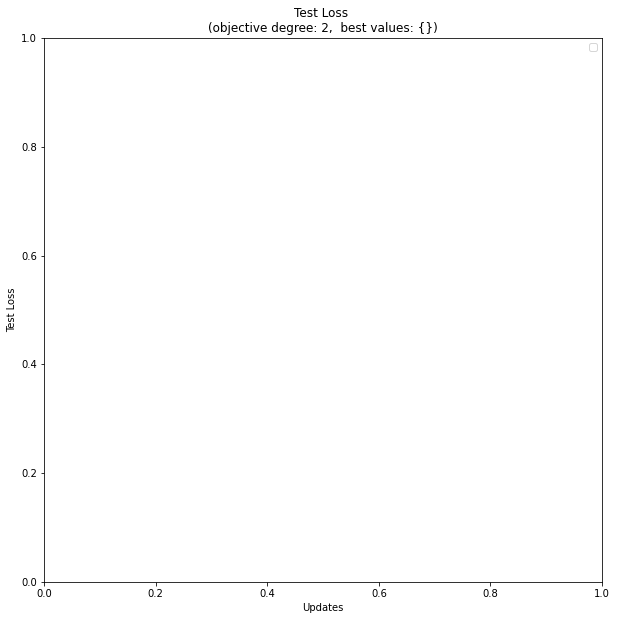

In [59]:
# best_vals = {}
# best_vals = {k: int(v*1000)/1000. for k, v in best_vals.items()} # A weird way to round numbers
# fig, ax = plt.subplots(figsize=(10,10))
# plt.title(f'Test Loss \n(objective degree: 2,  best values: {best_vals})')
# plt.ylabel('Test Loss')
# plt.legend()
# plt.xlabel('Updates')